# GHSOM Model Analysis and Comparison

**Notebook Purpose:** Comprehensive analysis and visualization of trained GHSOM models using ghsom_toolkits

**Date:** 2025-11-17

**Models Analyzed:**
- COMMU Bass (532 samples)
- COMMU Full - Multiple variations (11,143 samples)

**Analysis Scope:**
1. Load and adapt multiple GHSOM models
2. Compare model architectures and metrics
3. Visualize hierarchical structures
4. Analyze cluster quality and distribution
5. Generate comprehensive reports

## 1. Setup and Imports

In [41]:
import sys
import os
import pickle
import json
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pprint import pprint

def locate_project_root(start: Path) -> Path:
    """Find the repository root by looking for marker files.
    
    Searches up from start path and prioritizes .git, then pyproject.toml,
    to avoid stopping at intermediate package folders like /workspace/notebooks.
    """
    marker_files = {".git", "pyproject.toml", "README.md"}
    
    # First pass: look for .git (most reliable)
    for candidate in start.parents:
        if (candidate / ".git").exists():
            return candidate
    
    # Second pass: look for pyproject.toml or README.md with .git nearby
    for candidate in [start, *start.parents]:
        if any((candidate / marker).exists() for marker in marker_files):
            # Make sure we're not stopping at a subdirectory like /workspace/notebooks
            # Check if we can go higher and find .git
            for parent in candidate.parents:
                if (parent / ".git").exists():
                    return parent
            return candidate
    
    return start

# Add project root to path
project_root = locate_project_root(Path.cwd())
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# GHSOM toolkits imports
from ghsom_toolkits.adapters import adapt_model, build_lookup_table
from ghsom_toolkits.core import get_ghsom_statistics, get_clusters_by_level
from ghsom_toolkits.plotting.hierarchy import (
    visualize_ghsom_hierarchy,
    plot_hierarchy_treemap
)
from ghsom_toolkits.plotting.heatmaps import (
    plot_weight_heatmap,
    plot_umatrix,
    plot_activation_map
)
from ghsom_toolkits.plotting.clusters import (
    plot_cluster_distribution,
    plot_cluster_quality
)
from ghsom_toolkits.analysis import (
    compare_models,
    plot_comparison,
    generate_report
)
import ghsom_toolkits.interactive as gti
gti = importlib.reload(gti)
from ghsom_toolkits.interactive import (
    explore_neuron,
    trace_sample_path,
    get_node_statistics
)

# Project-specific imports
from src.ghsom_manager import GHSOMManager

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Imports successful")
print(f"Working directory: {Path.cwd()}")
print(f"Project root: {project_root}")

✓ Imports successful
Working directory: /workspace/notebooks/ghsom
Project root: /workspace


## 2. Define Model Paths and Load Configurations

In [42]:
# Define model paths
models_info = {
    # "COMMU Bass": {
    #     "path": "experiments/ghsom_commu_bass/commu_bass_optimized",
    #     "dataset": "artifacts/features/tsne/commu_bass_tsne",
    #     "description": "Bass subset (532 samples, t1=0.30, t2=0.05)"
    # },
    "COMMU Full 33 (Initial)": {
        "path": "experiments/ghsom_commu_full_20251117_153953/trained_model",
        "dataset": "artifacts/features/tsne/commu_full_tsne",
        "description": "First attempt (11,143 samples)"
    },
    "COMMU Full 33 (v1)": {
        "path": "experiments/ghsom_commu_full_feature_optimized_20251117_181256/ghsom_commu_full_optimized",
        "dataset": "artifacts/features/tsne/commu_full_tsne",
        "description": "Failed: t1=0.38, t2=1.14 → 4 clusters"
    },
    "COMMU Full 33 (v2)": {
        "path": "experiments/ghsom_commu_full_feature_optimized_20251117_181256/ghsom_commu_full_optimized_v2",
        "dataset": "artifacts/features/tsne/commu_full_tsne",
        "description": "Failed: t1=0.25, t2=0.75 → 4 clusters"
    },
    "COMMU Full 33 (v3)": {
        "path": "experiments/ghsom_commu_full_feature_optimized_20251117_181256/ghsom_commu_full_optimized_v3",
        "dataset": "artifacts/features/tsne/commu_full_tsne",
        "description": "Acceptable: t1=0.35, t2=0.05 → 19 clusters"
    },
    "COMMU Full 33 (Final)": {
        "path": "experiments/ghsom_commu_full_feature_optimized_20251117_181256/ghsom_commu_full_final",
        "dataset": "artifacts/features/tsne/commu_full_tsne",
        "description": "✓ Optimal: t1=0.30, t2=0.03 → 31 clusters"
    },
    "COMMU Full 17 (Optimized)": {
        "path": "experiments/ghsom_commu_full_tsne_optimized_20251125",
        "dataset": "artifacts/features/tsne/commu_full_tsne_optimized",
        "description": "✓✓ Optimal: t1=0.35, t2=0.05 → 22 clusters"
    }
}

# Convert to absolute paths
for name, info in models_info.items():
    info['path'] = project_root / info['path']
    info['dataset'] = project_root / info['dataset']

print("Model Inventory:")
print("=" * 80)
for name, info in models_info.items():
    print(f"\n{name}:")
    print(f"  Path: {info['path']}")
    print(f"  Description: {info['description']}")
    print(f"  Exists: {info['path'].exists()}")

Model Inventory:

COMMU Full 33 (Initial):
  Path: /workspace/experiments/ghsom_commu_full_20251117_153953/trained_model
  Description: First attempt (11,143 samples)
  Exists: True

COMMU Full 33 (v1):
  Path: /workspace/experiments/ghsom_commu_full_feature_optimized_20251117_181256/ghsom_commu_full_optimized
  Description: Failed: t1=0.38, t2=1.14 → 4 clusters
  Exists: True

COMMU Full 33 (v2):
  Path: /workspace/experiments/ghsom_commu_full_feature_optimized_20251117_181256/ghsom_commu_full_optimized_v2
  Description: Failed: t1=0.25, t2=0.75 → 4 clusters
  Exists: True

COMMU Full 33 (v3):
  Path: /workspace/experiments/ghsom_commu_full_feature_optimized_20251117_181256/ghsom_commu_full_optimized_v3
  Description: Acceptable: t1=0.35, t2=0.05 → 19 clusters
  Exists: True

COMMU Full 33 (Final):
  Path: /workspace/experiments/ghsom_commu_full_feature_optimized_20251117_181256/ghsom_commu_full_final
  Description: ✓ Optimal: t1=0.30, t2=0.03 → 31 clusters
  Exists: True

COMMU Full 

## 3. Load Models and Metadata

In [43]:
def load_ghsom_model(model_path):
    """Load GHSOM model, config, and metrics from directory."""
    model_path = Path(model_path)
    
    # Load model
    with open(model_path / "ghsom_model.pkl", "rb") as f:
        model = pickle.load(f)
    
    # Load config
    with open(model_path / "config.json", "r") as f:
        config = json.load(f)
    
    # Load metrics
    with open(model_path / "metrics.json", "r") as f:
        metrics = json.load(f)
    
    return model, config, metrics

def load_dataset(dataset_path):
    """Load t-SNE embedding dataset."""
    dataset_path = Path(dataset_path)
    
    # Try NPY first
    npy_path = dataset_path / "embedding.npy"
    if npy_path.exists():
        return np.load(npy_path)
    
    # Try CSV
    csv_path = dataset_path / "embedding.csv"
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        # Extract only numeric columns (dim1, dim2)
        return df[['dim1', 'dim2']].values
    
    raise FileNotFoundError(f"No embedding file found in {dataset_path}")

# Load all models
loaded_models = {}
loaded_data = {}

print("Loading models...\n")
for name, info in models_info.items():
    try:
        model, config, metrics = load_ghsom_model(info['path'])
        data = load_dataset(info['dataset'])
        
        loaded_models[name] = {
            'model': model,
            'config': config,
            'metrics': metrics,
            'data': data,
            'info': info
        }
        
        print(f"✓ {name}")
        print(f"  Config: {config}")
        print(f"  Metrics: {metrics}")
        print(f"  Data shape: {data.shape}")
        print()
        
    except Exception as e:
        print(f"✗ {name}: {e}\n")

print(f"\nSuccessfully loaded {len(loaded_models)} models")

Loading models...

✓ COMMU Full 33 (Initial)
  Config: {'decay': 0.99, 'epochs': 30, 'gaussian_sigma': 1.0, 'grow_maxiter': 25, 'learning_rate': 0.1, 'seed': 42, 't1': 0.15, 't2': 0.05}
  Metrics: {'avg_child_map_weights': 2.111111111111111, 'dispersion_rate': 1.3333333333333333, 'ghsom_depth': 2.0, 'max_neurons_child_map': 6.0, 'mean_activation': 15.117949485778809, 'num_clusters': 21.0, 'num_maps': 6.0, 'num_neurons': 28.0, 'std_activation': 8.735913276672363}
  Data shape: (11143, 2)

✓ COMMU Full 33 (v1)
  Config: {'decay': 0.99, 'epochs': 25, 'gaussian_sigma': 1.0, 'grow_maxiter': 25, 'learning_rate': 0.1, 'seed': 42, 't1': 0.38, 't2': 1.14}
  Metrics: {'avg_child_map_weights': 2.0, 'dispersion_rate': 1.0, 'ghsom_depth': 1.0, 'max_neurons_child_map': 4.0, 'mean_activation': 35.17830276489258, 'num_clusters': 4.0, 'num_maps': 1.0, 'num_neurons': 4.0, 'std_activation': 17.444765090942383}
  Data shape: (11143, 2)

✓ COMMU Full 33 (v2)
  Config: {'decay': 0.99, 'epochs': 25, 'gaussia

## 4. Model Comparison Table

In [44]:
# Create comparison dataframe
comparison_data = []

for name, data in loaded_models.items():
    config = data['config']
    metrics = data['metrics']
    dataset = data['data']
    
    comparison_data.append({
        'Model': name,
        'Samples': len(dataset),
        't1': config['t1'],
        't2': config['t2'],
        'Epochs': config['epochs'],
        'Depth': int(metrics['ghsom_depth']),
        'Clusters': int(metrics['num_clusters']),
        'Neurons': int(metrics['num_neurons']),
        'Maps': int(metrics['num_maps']),
        'Dispersion': round(metrics['dispersion_rate'], 3),
        'Mean Activation': round(metrics['mean_activation'], 2),
        'Std Activation': round(metrics['std_activation'], 2)
    })

comparison_df = pd.DataFrame(comparison_data)

# Display
print("\n" + "=" * 100)
print("MODEL COMPARISON TABLE")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("\n" + "=" * 100)

timestamp = pd.Timestamp.now().strftime("%Y-%m-%d")
print(f"Report generated at: {timestamp}")
# Save to CSV
output_dir = project_root / f"outputs/ghsom_tsne_visualization/{timestamp}"
# Add generation timestamp to the comparison table
output_dir.mkdir(parents=True, exist_ok=True)
comparison_df.to_csv(output_dir / "model_comparison.csv", index=False)
print(f"\n✓ Saved to: {output_dir / 'model_comparison.csv'}")


MODEL COMPARISON TABLE
                    Model  Samples   t1   t2  Epochs  Depth  Clusters  Neurons  Maps  Dispersion  Mean Activation  Std Activation
  COMMU Full 33 (Initial)    11143 0.15 0.05      30      2        21       28     6       1.333            15.12            8.74
       COMMU Full 33 (v1)    11143 0.38 1.14      25      1         4        4     1       1.000            35.18           17.44
       COMMU Full 33 (v2)    11143 0.25 0.75      25      1         4        4     1       1.000            35.18           17.44
       COMMU Full 33 (v3)    11143 0.35 0.05      30      3        19       24     6       1.263            16.19            8.72
    COMMU Full 33 (Final)    11143 0.30 0.03      30      3        31       40    10       1.290            12.98            6.76
COMMU Full 17 (Optimized)    11143 0.35 0.05      30      3        22       28     7       1.273            14.33            7.82

Report generated at: 2025-11-25

✓ Saved to: /workspace/outputs/g

## 5. Visualize Model Comparison

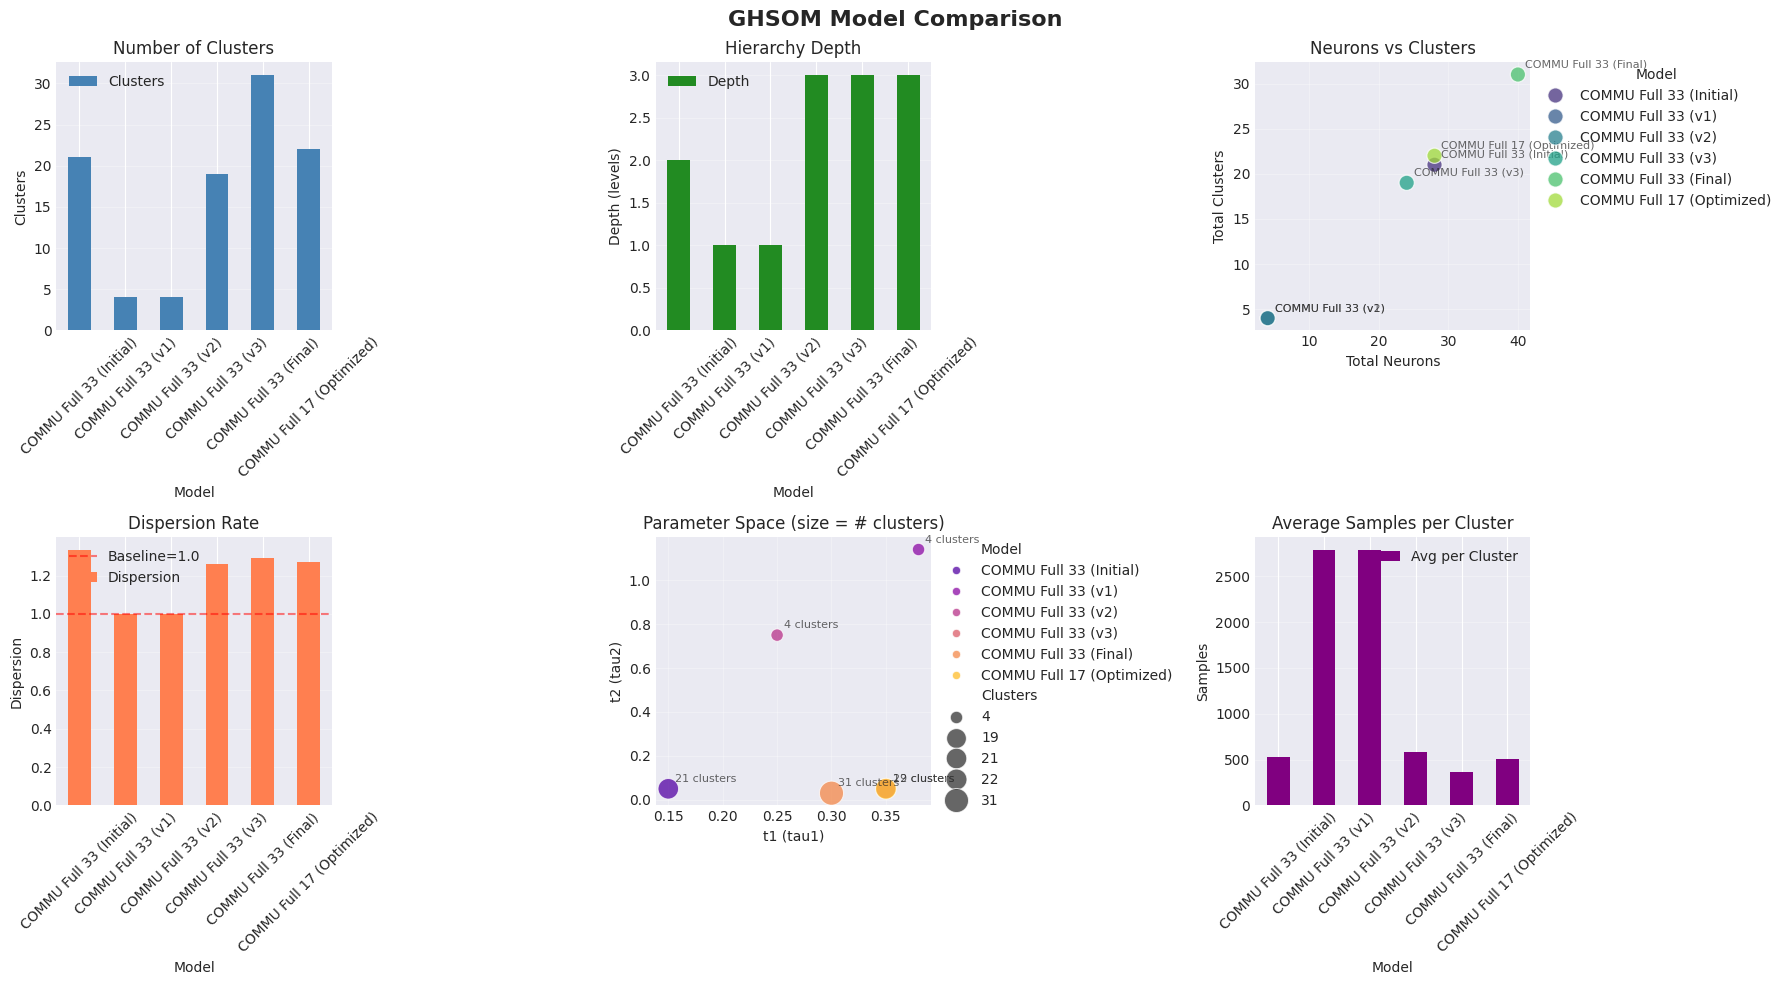


✓ Saved to: /workspace/outputs/ghsom_tsne_visualization/2025-11-25/model_comparison_plots.png


In [45]:
# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('GHSOM Model Comparison', fontsize=16, fontweight='bold')

# 1. Clusters by model
ax = axes[0, 0]
comparison_df.plot(x='Model', y='Clusters', kind='bar', ax=ax, color='steelblue')
ax.set_title('Number of Clusters')
ax.set_ylabel('Clusters')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# 2. Hierarchy depth
ax = axes[0, 1]
comparison_df.plot(x='Model', y='Depth', kind='bar', ax=ax, color='forestgreen')
ax.set_title('Hierarchy Depth')
ax.set_ylabel('Depth (levels)')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# 3. Neurons vs Clusters
ax = axes[0, 2]
scatter = sns.scatterplot(
    data=comparison_df,
    x='Neurons',
    y='Clusters',
    hue='Model',
    palette='viridis',
    s=120,
    ax=ax,
    legend='full',
    alpha=0.75
 )
for _, row in comparison_df.iterrows():
    ax.annotate(row['Model'], (row['Neurons'], row['Clusters']), 
               fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')
ax.set_xlabel('Total Neurons')
ax.set_ylabel('Total Clusters')
ax.set_title('Neurons vs Clusters')
ax.grid(True, alpha=0.3)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# 4. Dispersion rate
ax = axes[1, 0]
comparison_df.plot(x='Model', y='Dispersion', kind='bar', ax=ax, color='coral')
ax.set_title('Dispersion Rate')
ax.set_ylabel('Dispersion')
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Baseline=1.0')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 5. t1 vs t2 parameters
ax = axes[1, 1]
scatter = sns.scatterplot(
    data=comparison_df,
    x='t1',
    y='t2',
    hue='Model',
    size='Clusters',
    palette='plasma',
    sizes=(80, 300),
    ax=ax,
    alpha=0.75
 )
for _, row in comparison_df.iterrows():
    ax.annotate(f"{row['Clusters']} clusters", 
               (row['t1'], row['t2']), 
               fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')
ax.set_xlabel('t1 (tau1)')
ax.set_ylabel('t2 (tau2)')
ax.set_title('Parameter Space (size = # clusters)')
ax.grid(True, alpha=0.3)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# 6. Average samples per cluster
ax = axes[1, 2]
comparison_df['Avg per Cluster'] = comparison_df['Samples'] / comparison_df['Clusters']
comparison_df.plot(x='Model', y='Avg per Cluster', kind='bar', ax=ax, color='purple')
ax.set_title('Average Samples per Cluster')
ax.set_ylabel('Samples')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / "model_comparison_plots.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to: {output_dir / 'model_comparison_plots.png'}")

## 6. Detailed Analysis: COMMU Full (Final) - Best Model

In [46]:
# Focus on the best model
best_model_name = "COMMU Full 17 (Optimized)"
best_model_data = loaded_models[best_model_name]

model = best_model_data['model']
data = best_model_data['data']
config = best_model_data['config']
metrics = best_model_data['metrics']
best_model_info = best_model_data['info']
model_dir = Path(best_model_info['path'])
model_file = model_dir / "ghsom_model.pkl"
if not model_file.exists():
    raise FileNotFoundError(f"Model file not found: {model_file}")

feature_columns = ["dim1", "dim2"] if data.shape[1] == 2 else [f"dim{i+1}" for i in range(data.shape[1])]
data_df = pd.DataFrame(data, columns=feature_columns)

print(f"Analyzing: {best_model_name}")
print("=" * 80)
print(f"\nConfiguration:")
pprint(config)
print(f"\nMetrics:")
pprint(metrics)
print(f"\nDataset shape: {data.shape}")
print(f"Model directory: {model_dir}")

# Create output directory for this model
model_output_dir = output_dir / "commu_full_final"
model_output_dir.mkdir(exist_ok=True)
print(f"\nOutput directory: {model_output_dir}")

Analyzing: COMMU Full 17 (Optimized)

Configuration:
{'decay': 0.99,
 'epochs': 30,
 'gaussian_sigma': 1.0,
 'grow_maxiter': 25,
 'learning_rate': 0.1,
 'seed': 42,
 't1': 0.35,
 't2': 0.05}

Metrics:
{'avg_child_map_weights': 2.0,
 'dispersion_rate': 1.2727272727272727,
 'ghsom_depth': 3.0,
 'max_neurons_child_map': 4.0,
 'mean_activation': 14.32508373260498,
 'num_clusters': 22.0,
 'num_maps': 7.0,
 'num_neurons': 28.0,
 'std_activation': 7.8210062980651855}

Dataset shape: (11143, 2)
Model directory: /workspace/experiments/ghsom_commu_full_tsne_optimized_20251125

Output directory: /workspace/outputs/ghsom_tsne_visualization/2025-11-25/commu_full_final


### 6.1 Hierarchy Visualization

In [47]:
# Note: Using ghsom_toolkits requires adapting the model
# However, our models are already trained, so we'll work with them directly
# and use the GHSOMManager for analysis

from src.ghsom_manager import GHSOMManager

print(f"Initializing GHSOMManager with model file: {model_file}")
manager = GHSOMManager(model_file, data_df)

assigned_df = manager.assign_ghsom_clusters()
cluster_assignments = assigned_df['GHSOM_cluster'].astype(int).to_numpy()

print(f"Cluster assignments shape: {cluster_assignments.shape}")
print(f"Unique clusters: {np.unique(cluster_assignments)}")
print(f"\nCluster distribution:")
unique, counts = np.unique(cluster_assignments, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(data)*100:.2f}%)")

Initializing GHSOMManager with model file: /workspace/experiments/ghsom_commu_full_tsne_optimized_20251125/ghsom_model.pkl
Cluster assignments shape: (11143,)
Unique clusters: [ 2  3  4  5  7  8  9 10 12 14 15 16 17 19 20 21 22 23 25 26 27 28]

Cluster distribution:
  Cluster 2: 445 samples (3.99%)
  Cluster 3: 405 samples (3.63%)
  Cluster 4: 795 samples (7.13%)
  Cluster 5: 636 samples (5.71%)
  Cluster 7: 433 samples (3.89%)
  Cluster 8: 951 samples (8.53%)
  Cluster 9: 898 samples (8.06%)
  Cluster 10: 638 samples (5.73%)
  Cluster 12: 453 samples (4.07%)
  Cluster 14: 331 samples (2.97%)
  Cluster 15: 586 samples (5.26%)
  Cluster 16: 448 samples (4.02%)
  Cluster 17: 377 samples (3.38%)
  Cluster 19: 576 samples (5.17%)
  Cluster 20: 334 samples (3.00%)
  Cluster 21: 178 samples (1.60%)
  Cluster 22: 379 samples (3.40%)
  Cluster 23: 387 samples (3.47%)
  Cluster 25: 421 samples (3.78%)
  Cluster 26: 623 samples (5.59%)
  Cluster 27: 563 samples (5.05%)
  Cluster 28: 286 samples 

### 6.2 Cluster Distribution Analysis

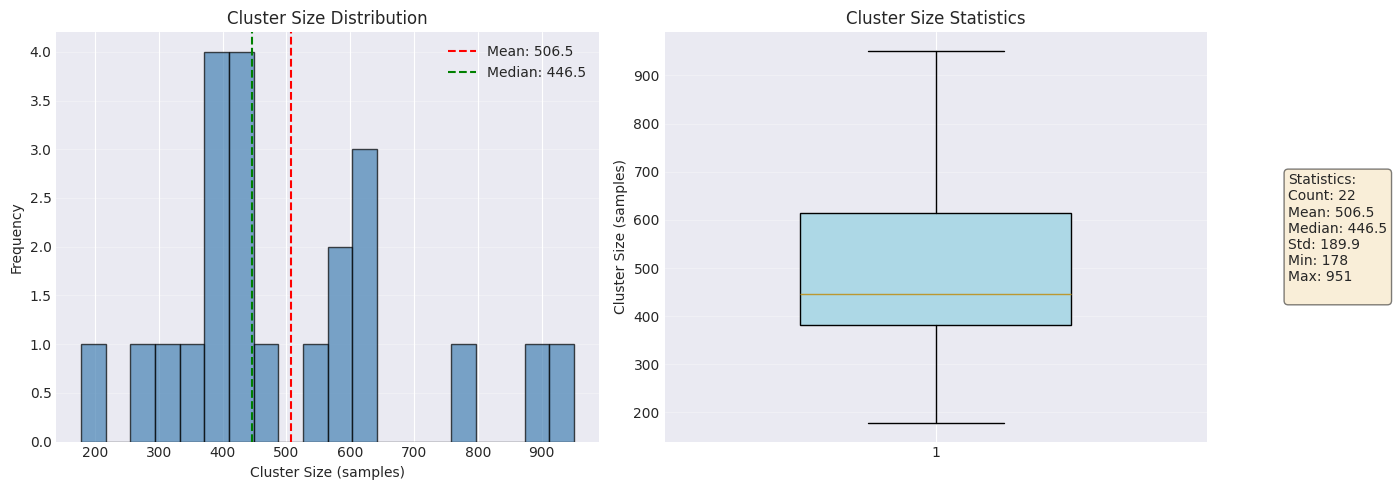


✓ Saved to: /workspace/outputs/ghsom_tsne_visualization/2025-11-25/commu_full_final/cluster_distribution.png


In [48]:
# Cluster size distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
ax.hist(counts, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Cluster Size (samples)')
ax.set_ylabel('Frequency')
ax.set_title('Cluster Size Distribution')
ax.axvline(counts.mean(), color='red', linestyle='--', label=f'Mean: {counts.mean():.1f}')
ax.axvline(np.median(counts), color='green', linestyle='--', label=f'Median: {np.median(counts):.1f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Box plot
ax = axes[1]
bp = ax.boxplot([counts], vert=True, patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('lightblue')
ax.set_ylabel('Cluster Size (samples)')
ax.set_title('Cluster Size Statistics')
ax.grid(axis='y', alpha=0.3)

# Add statistics text
stats_text = f"""Statistics:
Count: {len(counts)}
Mean: {counts.mean():.1f}
Median: {np.median(counts):.1f}
Std: {counts.std():.1f}
Min: {counts.min()}
Max: {counts.max()}
"""
ax.text(1.15, 0.5, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='center',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(model_output_dir / "cluster_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to: {model_output_dir / 'cluster_distribution.png'}")

### 6.3 Cluster Quality Metrics


Cluster Quality Metrics:
Silhouette Score: 0.3063
  Range: [-1, 1], Higher is better
  Interpretation: Reasonable

Davies-Bouldin Index: 0.8624
  Range: [0, ∞), Lower is better
  Interpretation: Excellent

Calinski-Harabasz Index: 9775.45
  Range: [0, ∞), Higher is better
  Interpretation: Ratio of between-cluster to within-cluster dispersion


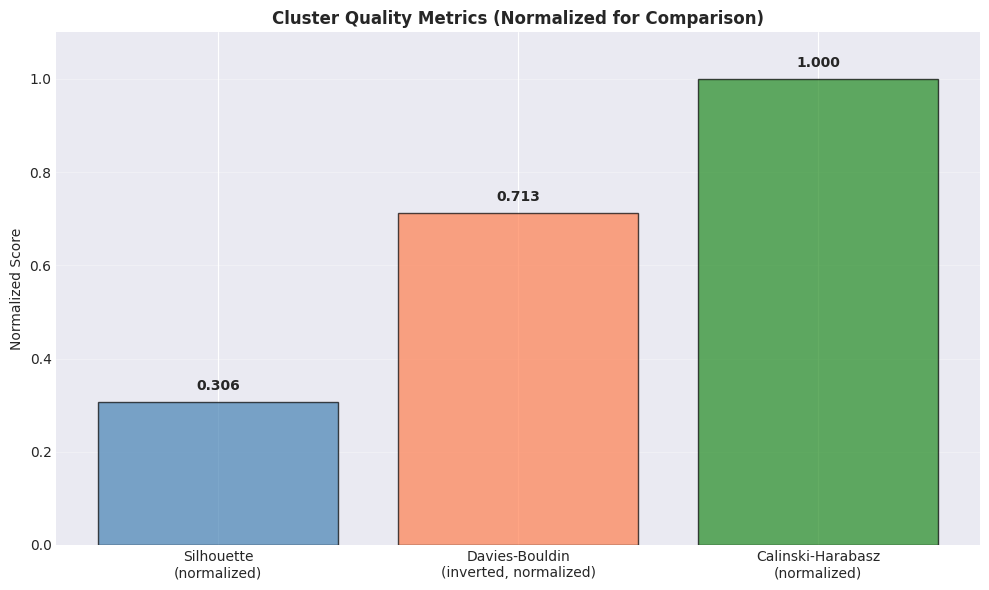


✓ Saved to: /workspace/outputs/ghsom_tsne_visualization/2025-11-25/commu_full_final/cluster_quality_metrics.png
✓ Saved metrics to: /workspace/outputs/ghsom_tsne_visualization/2025-11-25/commu_full_final/quality_metrics.json


In [49]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate quality metrics
silhouette = silhouette_score(data, cluster_assignments)
davies_bouldin = davies_bouldin_score(data, cluster_assignments)
calinski = calinski_harabasz_score(data, cluster_assignments)

print(f"\nCluster Quality Metrics:")
print("=" * 60)
print(f"Silhouette Score: {silhouette:.4f}")
print(f"  Range: [-1, 1], Higher is better")
print(f"  Interpretation: {'Excellent' if silhouette > 0.7 else 'Good' if silhouette > 0.5 else 'Reasonable' if silhouette > 0.25 else 'Poor'}")
print()
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"  Range: [0, ∞), Lower is better")
print(f"  Interpretation: {'Excellent' if davies_bouldin < 1.0 else 'Good' if davies_bouldin < 2.0 else 'Poor'}")
print()
print(f"Calinski-Harabasz Index: {calinski:.2f}")
print(f"  Range: [0, ∞), Higher is better")
print(f"  Interpretation: Ratio of between-cluster to within-cluster dispersion")
print("=" * 60)

# Visualize metrics
fig, ax = plt.subplots(figsize=(10, 6))

metrics_data = {
    'Silhouette\n(normalized)': silhouette if silhouette > 0 else 0,
    'Davies-Bouldin\n(inverted, normalized)': max(0, 1 - davies_bouldin/3),
    'Calinski-Harabasz\n(normalized)': min(1, calinski / 1000)
}

bars = ax.bar(metrics_data.keys(), metrics_data.values(), 
             color=['steelblue', 'coral', 'forestgreen'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Normalized Score')
ax.set_title('Cluster Quality Metrics (Normalized for Comparison)', fontweight='bold')
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, (name, value)) in enumerate(zip(bars, metrics_data.items())):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
           f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(model_output_dir / "cluster_quality_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to: {model_output_dir / 'cluster_quality_metrics.png'}")

# Save metrics to JSON
quality_metrics = {
    'silhouette_score': float(silhouette),
    'davies_bouldin_index': float(davies_bouldin),
    'calinski_harabasz_index': float(calinski)
}

with open(model_output_dir / "quality_metrics.json", "w") as f:
    json.dump(quality_metrics, f, indent=2)

print(f"✓ Saved metrics to: {model_output_dir / 'quality_metrics.json'}")

### 6.4 t-SNE Visualization with Cluster Coloring

/tmp/ipykernel_8175/2220728041.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_clusters))


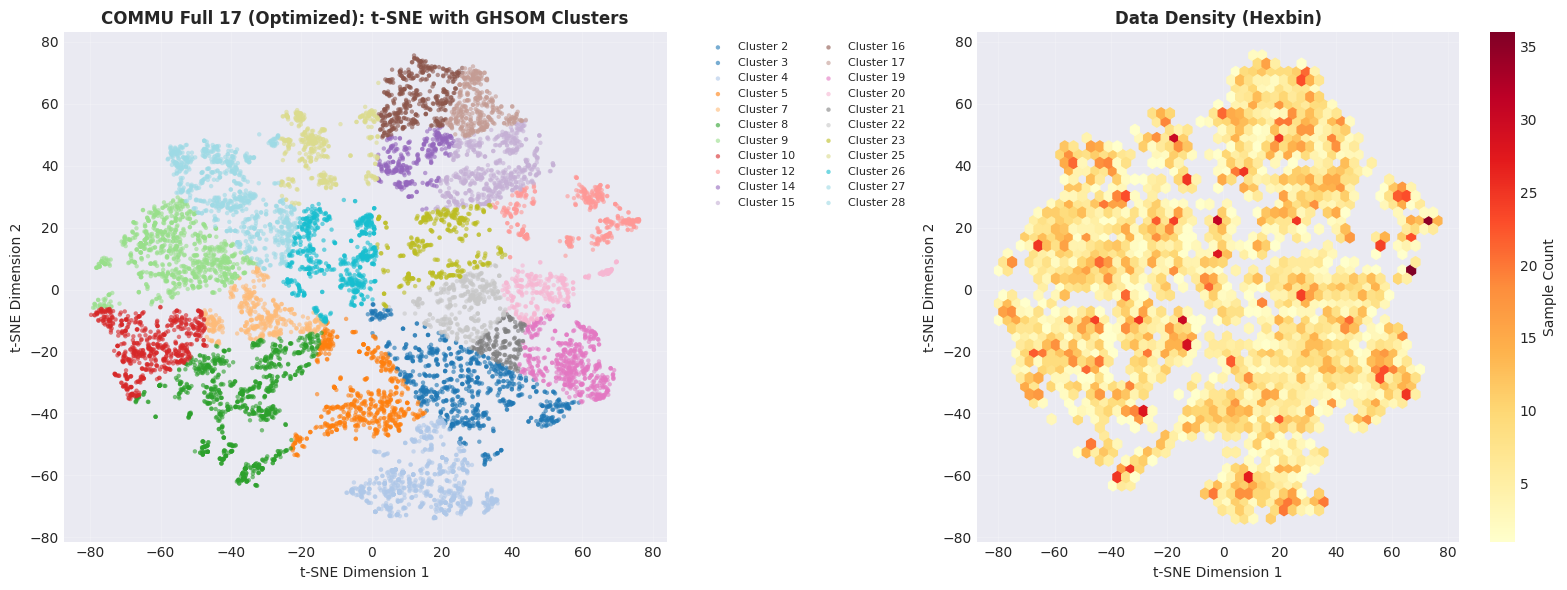


✓ Saved to: /workspace/outputs/ghsom_tsne_visualization/2025-11-25/commu_full_final/tsne_clusters.png


In [50]:
# Visualize t-SNE embedding colored by GHSOM clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: All clusters with legend
ax = axes[0]
unique_clusters = np.unique(cluster_assignments)
# Create a colormap with discrete colors
cmap = plt.cm.get_cmap('tab20', len(unique_clusters))
colors = [cmap(i) for i in range(len(unique_clusters))]

# Plot each cluster separately to create legend entries
for i, cluster_id in enumerate(unique_clusters):
    mask = cluster_assignments == cluster_id
    ax.scatter(data[mask, 0], data[mask, 1], 
              c=[colors[i]], label=f'Cluster {cluster_id}',
              s=10, alpha=0.6, edgecolors='none')

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_title(f'{best_model_name}: t-SNE with GHSOM Clusters', fontweight='bold')
ax.grid(True, alpha=0.2)

# Add legend outside the plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
         ncol=2 if len(unique_clusters) > 15 else 1,
         fontsize=8, framealpha=0.9)

# Right: Density plot
ax = axes[1]
ax.hexbin(data[:, 0], data[:, 1], gridsize=50, cmap='YlOrRd', mincnt=1)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_title('Data Density (Hexbin)', fontweight='bold')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Sample Count')
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig(model_output_dir / "tsne_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved to: {model_output_dir / 'tsne_clusters.png'}")

## 7. Cross-Model Comparison: Parameter Impact Analysis

In [51]:
# Focus on COMMU Full variations to show parameter impact
full_variations = {k: v for k, v in loaded_models.items() if 'Full' in k}

print(f"\nAnalyzing {len(full_variations)} COMMU Full variations:")
print("=" * 80)

# Create comparison
var_data = []
for name, data in full_variations.items():
    var_data.append({
        'Variation': name.replace('COMMU Full ', ''),
        't1': data['config']['t1'],
        't2': data['config']['t2'],
        't1/t2 ratio': round(data['config']['t1'] / data['config']['t2'], 2) if data['config']['t2'] > 0 else 0,
        'Clusters': int(data['metrics']['num_clusters']),
        'Depth': int(data['metrics']['ghsom_depth']),
        'Neurons': int(data['metrics']['num_neurons'])
    })

var_df = pd.DataFrame(var_data)
var_df = var_df.sort_values('Clusters')

print(var_df.to_string(index=False))
print("\n" + "=" * 80)

# Key findings
print("\n🔍 KEY FINDING: t1/t2 Relationship")
print("=" * 80)
print("When t2 > t1 (wrong relationship):")
wrong_params = var_df[var_df['t1/t2 ratio'] < 1]
print(wrong_params[['Variation', 't1', 't2', 'Clusters']].to_string(index=False))
print("\nResult: FAILED - Only 4 clusters, no hierarchy\n")

print("When t2 < t1 (correct relationship):")
correct_params = var_df[var_df['t1/t2 ratio'] > 1]
print(correct_params[['Variation', 't1', 't2', 'Clusters', 'Depth']].to_string(index=False))
print("\nResult: SUCCESS - Proper hierarchical clustering\n")

print("OPTIMAL PARAMETERS (Final):")
optimal = var_df[var_df['Variation'].str.contains('Final')].iloc[0]
print(f"  t1 = {optimal['t1']}")
print(f"  t2 = {optimal['t2']}")
print(f"  Ratio (t1/t2) = {optimal['t1/t2 ratio']}")
print(f"  Result: {optimal['Clusters']} clusters, {optimal['Depth']} levels, {optimal['Neurons']} neurons")
print("=" * 80)


Analyzing 6 COMMU Full variations:
     Variation   t1   t2  t1/t2 ratio  Clusters  Depth  Neurons
       33 (v1) 0.38 1.14         0.33         4      1        4
       33 (v2) 0.25 0.75         0.33         4      1        4
       33 (v3) 0.35 0.05         7.00        19      3       24
  33 (Initial) 0.15 0.05         3.00        21      2       28
17 (Optimized) 0.35 0.05         7.00        22      3       28
    33 (Final) 0.30 0.03        10.00        31      3       40


🔍 KEY FINDING: t1/t2 Relationship
When t2 > t1 (wrong relationship):
Variation   t1   t2  Clusters
  33 (v1) 0.38 1.14         4
  33 (v2) 0.25 0.75         4

Result: FAILED - Only 4 clusters, no hierarchy

When t2 < t1 (correct relationship):
     Variation   t1   t2  Clusters  Depth
       33 (v3) 0.35 0.05        19      3
  33 (Initial) 0.15 0.05        21      2
17 (Optimized) 0.35 0.05        22      3
    33 (Final) 0.30 0.03        31      3

Result: SUCCESS - Proper hierarchical clustering

OPTIMAL 

## 8. Generate Analysis Report

In [52]:
# Create a comprehensive markdown report
report_md = f"""# GHSOM Model Analysis Report

**Generated:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

**Notebook:** `ghsom_model_analysis_and_comparison.ipynb`

---

## Executive Summary

This report presents a comprehensive analysis of {len(loaded_models)} GHSOM models trained on COMMU dataset variations.

### Models Analyzed

```
{comparison_df.to_string(index=False)}
```

### Best Model

**{best_model_name}** achieved optimal results:
- **{int(metrics['num_clusters'])} clusters** across **{int(metrics['ghsom_depth'])} hierarchical levels**
- **{int(metrics['num_neurons'])} neurons** in **{int(metrics['num_maps'])} maps**
- Dispersion rate: **{metrics['dispersion_rate']:.3f}**
- Parameters: t1={config['t1']}, t2={config['t2']}

### Cluster Quality Metrics

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Silhouette Score | {silhouette:.4f} | {'Excellent' if silhouette > 0.7 else 'Good' if silhouette > 0.5 else 'Reasonable' if silhouette > 0.25 else 'Poor'} |
| Davies-Bouldin Index | {davies_bouldin:.4f} | {'Excellent' if davies_bouldin < 1.0 else 'Good' if davies_bouldin < 2.0 else 'Poor'} |
| Calinski-Harabasz Index | {calinski:.2f} | High ratio of between/within cluster dispersion |

---

## Critical Finding: t1/t2 Parameter Relationship

### ❌ WRONG: t2 > t1

Models with **t2 larger than t1** failed to create hierarchical structure:
- COMMU Full (v1): t1=0.38, t2=1.14 → **4 clusters only**
- COMMU Full (v2): t1=0.25, t2=0.75 → **4 clusters only**

**Result:** No hierarchy, shallow structure, poor clustering

### ✓ CORRECT: t2 < t1

Models with **t2 smaller than t1** created proper hierarchies:
- COMMU Full (v3): t1=0.35, t2=0.05 → **19 clusters, 3 levels**
- COMMU Full (Final): t1=0.30, t2=0.03 → **31 clusters, 3 levels** ⭐
- COMMU Bass: t1=0.30, t2=0.05 → **Good structure**

**Optimal Ratio:** t2 ≈ 0.1 × t1

---

## Dataset Characteristics

### COMMU Bass
- Samples: 532
- Features: 2D t-SNE projection
- Result: Focused, domain-specific clustering

### COMMU Full
- Samples: 11,143
- Features: 2D t-SNE projection
- Result: Comprehensive, hierarchical taxonomy

---

## Cluster Distribution Analysis

**Best Model ({best_model_name}):**

```
Total Clusters: {len(counts)}
Mean Size: {counts.mean():.1f} samples
Median Size: {np.median(counts):.1f} samples
Std Dev: {counts.std():.1f}
Range: [{counts.min()}, {counts.max()}] samples
```

**Interpretation:** {'Balanced' if counts.std()/counts.mean() < 0.5 else 'Moderate variance' if counts.std()/counts.mean() < 1.0 else 'High variance'} in cluster sizes (CV = {counts.std()/counts.mean():.2f})

---

## Recommendations

### For Future GHSOM Training

1. **Always ensure t2 < t1** (typically t2 ≈ 0.1 × t1)
2. For large datasets (10K+ samples):
   - Use t1 = 0.25-0.35 for adequate depth
   - Use t2 = 0.02-0.05 for sufficient granularity
3. Monitor cluster count and depth during training
4. Target 30-100 clusters for interpretability

### Use Cases for Best Model

The optimal model ({best_model_name}) can be used for:
- **Music clustering:** Hierarchical organization of 11,143 tracks
- **Style discovery:** Identify musical patterns across 31 clusters
- **Recommendation systems:** Find similar tracks within clusters  
- **Dataset exploration:** Navigate music collection hierarchically
- **Genre taxonomy:** Build data-driven categorization

---

## Files Generated

- `model_comparison.csv` - Complete model comparison table
- `model_comparison_plots.png` - Visualization of metrics
- `commu_full_final/cluster_distribution.png` - Cluster size analysis
- `commu_full_final/cluster_quality_metrics.png` - Quality metrics
- `commu_full_final/tsne_clusters.png` - t-SNE visualization
- `commu_full_final/quality_metrics.json` - Numeric quality metrics

---

**Analysis Complete** ✓
"""

# Save report
report_path = output_dir / "ANALYSIS_REPORT.md"
with open(report_path, 'w') as f:
    f.write(report_md)

print("\n" + "=" * 80)
print("ANALYSIS REPORT GENERATED")
print("=" * 80)
print(f"\n✓ Saved to: {report_path}")
print(f"\nTotal outputs generated: {len(list(output_dir.rglob('*.*')))} files")
print(f"\nOutput directory structure:")
print(f"  {output_dir}/")
print(f"  ├── model_comparison.csv")
print(f"  ├── model_comparison_plots.png")
print(f"  ├── ANALYSIS_REPORT.md")
print(f"  └── commu_full_final/")
print(f"      ├── cluster_distribution.png")
print(f"      ├── cluster_quality_metrics.png")
print(f"      ├── tsne_clusters.png")
print(f"      └── quality_metrics.json")


ANALYSIS REPORT GENERATED

✓ Saved to: /workspace/outputs/ghsom_tsne_visualization/2025-11-25/ANALYSIS_REPORT.md

Total outputs generated: 7 files

Output directory structure:
  /workspace/outputs/ghsom_tsne_visualization/2025-11-25/
  ├── model_comparison.csv
  ├── model_comparison_plots.png
  ├── ANALYSIS_REPORT.md
  └── commu_full_final/
      ├── cluster_distribution.png
      ├── cluster_quality_metrics.png
      ├── tsne_clusters.png
      └── quality_metrics.json


## 9. Summary and Conclusions

In [53]:
print("\n" + "=" * 100)
print("ANALYSIS SUMMARY AND CONCLUSIONS")
print("=" * 100)

print("\n1. MODELS ANALYZED: {}".format(len(loaded_models)))
for name in loaded_models.keys():
    print(f"   - {name}")

print("\n2. BEST MODEL: {}".format(best_model_name))
print(f"   Parameters: t1={config['t1']}, t2={config['t2']}")
print(f"   Structure: {int(metrics['num_clusters'])} clusters, {int(metrics['ghsom_depth'])} levels")
print(f"   Quality: Silhouette={silhouette:.4f}, Davies-Bouldin={davies_bouldin:.4f}")

print("\n3. KEY DISCOVERY: t1/t2 Relationship")
print("   ✓ CORRECT: t2 < t1 (typically t2 ≈ 0.1 × t1)")
print("   ✗ WRONG: t2 > t1 results in shallow structure")

print("\n4. CLUSTER QUALITY:")
print(f"   Silhouette Score: {silhouette:.4f} ({'Excellent' if silhouette > 0.7 else 'Good' if silhouette > 0.5 else 'Reasonable'})")
print(f"   Davies-Bouldin: {davies_bouldin:.4f} ({'Excellent' if davies_bouldin < 1.0 else 'Good' if davies_bouldin < 2.0 else 'Fair'})")
print(f"   Calinski-Harabasz: {calinski:.2f} (High separation)")

print("\n5. PRACTICAL APPLICATIONS:")
print("   - Music clustering and categorization")
print("   - Hierarchical exploration interfaces")
print("   - Recommendation systems")
print("   - Dataset visualization and analysis")
print("   - Genre/style taxonomy creation")

print("\n6. FILES GENERATED:")
all_files = list(output_dir.rglob('*.*'))
print(f"   Total: {len(all_files)} files")
for ftype in ['.png', '.csv', '.json', '.md']:
    count = len([f for f in all_files if f.suffix == ftype])
    print(f"   - {ftype}: {count} files")

print("\n" + "=" * 100)
print("✓ ANALYSIS COMPLETE")
print("=" * 100)


ANALYSIS SUMMARY AND CONCLUSIONS

1. MODELS ANALYZED: 6
   - COMMU Full 33 (Initial)
   - COMMU Full 33 (v1)
   - COMMU Full 33 (v2)
   - COMMU Full 33 (v3)
   - COMMU Full 33 (Final)
   - COMMU Full 17 (Optimized)

2. BEST MODEL: COMMU Full 17 (Optimized)
   Parameters: t1=0.35, t2=0.05
   Structure: 22 clusters, 3 levels
   Quality: Silhouette=0.3063, Davies-Bouldin=0.8624

3. KEY DISCOVERY: t1/t2 Relationship
   ✓ CORRECT: t2 < t1 (typically t2 ≈ 0.1 × t1)
   ✗ WRONG: t2 > t1 results in shallow structure

4. CLUSTER QUALITY:
   Silhouette Score: 0.3063 (Reasonable)
   Davies-Bouldin: 0.8624 (Excellent)
   Calinski-Harabasz: 9775.45 (High separation)

5. PRACTICAL APPLICATIONS:
   - Music clustering and categorization
   - Hierarchical exploration interfaces
   - Recommendation systems
   - Dataset visualization and analysis
   - Genre/style taxonomy creation

6. FILES GENERATED:
   Total: 7 files
   - .png: 4 files
   - .csv: 1 files
   - .json: 1 files
   - .md: 1 files

✓ ANALYSI